# Coding CNNs from Scratch with Pytorch

In this assignment you will code a famous CNN architecture AlexNet (https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) to classify images from the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 10 classes of natural images such as vehicles or animals. AlexNet is a landmark architecture because it was one of the first extremely deep CNNs trained on GPUs, and achieved state-of-the-art performance in the ImageNet challenge in 2012. 


A lot of code will already be written to familiarize yourself with PyTorch, but you will have to fill in parts that will apply your knowledge of CNNs. Additionally, there are some numbered questions that you must answer either in a separate document, or in this notebook. Some questions may require you to do a little research. To type in the notebook, you can insert a text cell. 

Let's start by installing PyTorch and the torchvision package below. Due to the size of the network, you will have to run on a GPU. So, click on the Runtime dropdown, then Change Runtime Type, then GPU for the hardware accelerator. 

In [ ]:
!pip install pytorch
!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device('cuda')  
print(device)

cuda


### 1. In the following cell, we are employing something called "data augmentation" with random horizontal and vertical flips. So when training data is fed into the network, it is ranadomly transformed. What are advantages of this?


> Sol: **Data augmentation** is an effective method to increase data scale and reduce model overfitting.






### 2. We normalize with the line transforms.Normalize((0.5,), (0.5,)). What are the benefits of normalizing data? 
>Sol: `Normalize()` function is used to transform data into standard Gaussian distribution, which can accelerate the convergence of the model.  



In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from math import ceil

BATCH_SIZE = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)


torch.manual_seed(43)
val_size = 10000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds), len(val_ds))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


num_steps =  ceil(len(train_ds) / BATCH_SIZE)
num_steps

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE)

You can insert an integer  into the code trainset[#insert integer] to visualize images from the training set. Some of the images might look weird because they have been randomly flipped according to our data augmentation scheme. 

Label (numeric): 9
Label (textual): truck


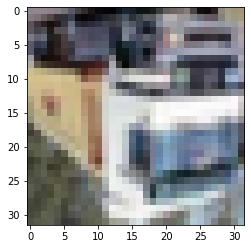

In [ ]:
img, label = trainset[1]
plt.imshow((img.permute((1, 2, 0))+1)/2)
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [ ]:
print(len(classes))

10


Now comes the fun part. You will have to put in the correct parameters into different torch.nn functions in order to convolve and downsample the image into the correct dimensionality for classification. Think of it as a puzzle. You will insert the parameters where there is a comment #TODO. 

In [ ]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        #Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        #we must flatten our feature maps before feeding into fully connected layers
        # x = x.contiguous().view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

Below we are initializing our model with a weight scheme.

In [ ]:
net = Discriminator()

def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
net = net.to(device)
net.apply(weights_init)

Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=Tru

# 3. Notice above in our network architecture, we have what are called "Dropout" layers. What is the point of these?



> Sol: We can define the dropout as follow:
> 1.   Firstly, some hidden neurons in the network are **randomly (temporarily) deleted**, and the input and output neurons remain unchanged even if the output of some neurons is 0
> 2.   The input is then propagated forward through the modified network, and the resulting loss results are propagated back through the modified network.  After performing this process in a small group of training samples, the corresponding parameters **(W, b)** were updated in accordance with the random gradient descent method on the neurons that were not deleted.  
>By introducing dropout layers into the neural network structure during training, **overfitting can be effectively avoided**  






Defining our cost/loss function, which is cross-entropy loss. We also define our optimizer with hyperparameters: learning rate and betas. 

In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.0002,
    betas = (0.5, 0.999)
)

Below we actually train our network. Run for just 10 epochs. It takes some time. Wherever there is the comment #TODO, you must insert code.

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.to(device))#TODO     
        #pass input data into network to get outputs
        loss = criterion(outputs, labels.to(device))
        loss.backward()  #calculate gradients
        optimizer.step() #take gradient descent step      
        running_loss += loss.item()
            
    print("E:{}, Train Loss:{}".format(
                epoch+1,
                running_loss / num_steps
            )
        )
        
        
        
    #validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data#TODO: load images and labels from validation loader
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
            loss = criterion(outputs, labels)      #calculate validation loss
            val_loss += loss.item()
    val_loss /=num_steps
    print('Accuracy of 10000 val images: {}'.format( correct / total))
    print('Val Loss: {}'.format( val_loss))

print('Finished Training')

E:1, Train Loss:1.9191300451755524
Accuracy of 10000 val images: 0.3577
Val Loss: 0.4182637628912926
E:2, Train Loss:1.5371633660793305
Accuracy of 10000 val images: 0.4706
Val Loss: 0.3578905487060547
E:3, Train Loss:1.3599897265434264
Accuracy of 10000 val images: 0.5225
Val Loss: 0.3277172115445137
E:4, Train Loss:1.2420964270830155
Accuracy of 10000 val images: 0.5417
Val Loss: 0.31233872085809705
E:5, Train Loss:1.1474959242343903
Accuracy of 10000 val images: 0.5636
Val Loss: 0.30339749246835707
E:6, Train Loss:1.0740292391180992
Accuracy of 10000 val images: 0.5938
Val Loss: 0.2819275915622711
E:7, Train Loss:1.0067521919310094
Accuracy of 10000 val images: 0.6081
Val Loss: 0.2752533419430256
E:8, Train Loss:0.9469500032067298
Accuracy of 10000 val images: 0.6191
Val Loss: 0.2691690950095654
E:9, Train Loss:0.8973482114076614
Accuracy of 10000 val images: 0.6428
Val Loss: 0.25562571570277215
E:10, Train Loss:0.8473449007421732
Accuracy of 10000 val images: 0.6549
Val Loss: 0.250

#  

## 4. If we train for more epochs, our accuracy/performance will increase. What happens if we train for too long though? What method can be employed to mitigate this?

>Sol: If the number of training rounds is too many, the over-fitting phenomenon will occur, that is, the loss function of the model is small in the training data, and the prediction accuracy is high.  However, the loss function of the test data is relatively large and the prediction accuracy is low.

>Methods to avoid over-fitting are concluded as follow:
>  1. Reduce the size of the neural network
>  2. Adding Dropout layers
>  3. Regularization (L1, L2)
>  4. Enlarge the dataset




## 5. Try increasing learning rate and look at the metrics for training and validation data? What do you notice? Why do think this is happening?

>Sol: When we gradually increase the learning rate, the **speed of model convergence** will be accelerated, but when the learning rate exceeds a certain value, the value of the loss will **fluctuate**. That is because the model cannot(unable) **converge to the global minimum** due to the large learning rate.


We can see the performance on the testing set now. 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of 10000 test images: {}'.format( correct / total))

Accuracy of 10000 test images: 0.661
